In [1]:
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import psutil
import scipy
from skimage.external.tifffile import TiffFile
import sys
# import time
import logging

try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    filename="/tmp/caiman.log",
                    level=logging.DEBUG)


In [2]:
import pandas as pd

In [3]:
from sys import path as syspath
syspath.append(os.path.expanduser("~/srdjan_functs/"))

In [4]:
from physio_def_1 import rebin

In [5]:
import caiman as cm
from caiman.motion_correction import MotionCorrect#, tile_and_correct, motion_correction_piecewise
# from caiman.utils.utils import download_demo

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
del cm.movie.play

In [7]:
%config InlineBackend.figure_format = 'retina'

In [8]:
# npzFile = "local_data/Sandra/2020_01_14/Experiment45b/Experiment45b_2_Series007.npz"
# npzFile = "local_data/testdir/Experiment38a_18_Series040.npz"
npzFile = "local_data/testdir/Experiment38a_7_Series016.npz"
metadata = pd.read_csv(npzFile.replace("npz","txt")).loc[0]
npzData = np.load(npzFile)

In [102]:
orig_images = npzData["data"]

In [138]:
orig_images.shape

(30304, 128, 128)

In [105]:
time = np.arange(len(orig_images))/metadata.freq

In [10]:
# subsampling frequency for Motion Correction
freqMC = metadata.freq/30#.06*50
n_rebin = int(metadata.freq/freqMC)

In [11]:
rebinned_images = rebin(orig_images,n_rebin).astype("float32")
# frequency = metadata.freq/n_rebin
# base_name = os.path.split(npzFile)[1].rstrip(".npz")+f"_f={frequency:.2g}Hz"
base_name = "tmp"

In [12]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

In [13]:
fnames = cm.save_memmap([rebinned_images], base_name=base_name, order='C', border_to_0=0, dview=dview)

In [14]:
m_rebinned = cm.load(fnames)

In [15]:
from caiman.source_extraction.cnmf import params as params

In [16]:
pwRigid = True
# motion correction parameters
opts = params.CNMFParams(params_dict={
    'fnames'              : fnames,
    "max_deviation_rigid" : 0,
    # 'max_shifts'        : (1, 1),  # maximum allowed rigid shift
    'border_nan'          : "copy",
    'pw_rigid'            : pwRigid,
    'gSig_filt'           : (3, 3),  # size of high pass spatial filtering, used in 1p data,
    'nonneg_movie'        : True
}) 

mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))

In [17]:
if not pwRigid:
    while True:
        print ("constraining mc.max_deviation_rigid at ", mc.max_deviation_rigid)
        mc.motion_correct(save_movie=True);
        maxshift = np.abs(mc.shifts_rig).max()
        if maxshift<mc.max_deviation_rigid:
            break
        else:
            mc.max_deviation_rigid += 1
    mc.shifts_rig = np.array(mc.shifts_rig)
    plt.plot(mc.shifts_rig)
    m_after_rigid = cm.load(mc.fname_tot_rig)

In [18]:
patchSizeAbs = 100 # in micrometers
patchSizePx = int(patchSizeAbs/metadata.pxSize)
if patchSizePx%2:
    patchSizePx -= 1

Lstride = int(patchSizePx*.7)
Loverlap = patchSizePx - Lstride
print (Lstride, Loverlap)

mc.strides  = (Lstride,)*2   # start a new patch for pw-rigid motion correction every x pixels,
mc.overlaps = (Loverlap,)*2  # between pathes (size of patch strides+overlaps),


32 14


In [19]:
# % For setting the number of patches per dimension
# nStridesX, nStridesY = 8,8
# LstrideX = int(metadata.X*metadata.pxSize/patchSize)
# LoverlapX = LstrideX//2+1
# LstrideY = int(metadata.Y*metadata.pxSize/patchSize)
# LoverlapY = LstrideY//2+1
# # LstrideX, LoverlapX = metadata.X//nStridesX, metadata.X%nStridesX  
# # LstrideY, LoverlapY = metadata.Y//nStridesY, metadata.Y%nStridesY  
# # LstrideX, LoverlapX = dims[0]//nStridesX, dims[0]%nStridesX  
# # LstrideY, LoverlapY = dims[1]//nStridesY, dims[1]%nStridesY  
# LstrideX, LoverlapX, LstrideY, LoverlapY
# mc.strides  = ( LstrideX,  LstrideY)   # start a new patch for pw-rigid motion correction every x pixels,
# mc.overlaps = (LoverlapX, LoverlapY)   # between pathes (size of patch strides+overlaps),

In [20]:
mc.max_deviation_rigid = 3  # maximum deviation allowed for patch with respect to rigid shifts

In [21]:
mc.pw_rigid = True  # turn the flag to True for pw-rigid motion correction
mc.motion_correct(save_movie=True)

In [22]:
# m_original      = cm.load(mc.fname)
# m_after_rigid   = cm.load(mc.fname_tot_rig)
m_after_pwrigid = cm.load(mc.fname_tot_els)

100%|██████████| 1/1 [00:00<00:00, 16.44it/s]


In [27]:
m_tmp = mc.apply_shifts_movie(mc.fname,
#                               rigid_shifts=False
                             )

100%|██████████| 1/1 [00:00<00:00, 16.65it/s]


In [28]:
np.abs(m_tmp-m_after_pwrigid).max()

movie(7.6293945e-06, dtype=float32)

In [26]:
mc.x_shifts_els = np.array(mc.x_shifts_els)
mc.y_shifts_els = np.array(mc.y_shifts_els)

In [31]:
origShifts = np.stack([mc.x_shifts_els,mc.y_shifts_els])

In [32]:
origShifts.shape

(2, 1044, 16)

In [62]:
np.concatenate([np.zeros((3,2)), np.zeros((5,2))])

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [65]:
from numba import jit,prange
@jit 
def runningAverage(x_,filterSize):
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
    delta = filterSize//2
    out = np.zeros_like(x_)
    # x_ = np.hstack([[x_[0]]*delta,x_,[x_[-1]]*delta])
    x_ = np.concatenate([x_[:delta][::-1], x_, x_[-delta:][::-1]])
#     print (x_.shape, out.shape)
    for i in prange(len(out)):
        out[i] = np.nanmean(x_[i:i+filterSize], axis=0)
    return out

In [77]:
# mc.x_shifts_els, mc.y_shifts_els = np.repeat(origShifts[:,:10],1,axis=1)
mc.x_shifts_els, mc.y_shifts_els = [runningAverage(shift,1) for shift in origShifts]

In [78]:
m_wrong = mc.apply_shifts_movie(mc.fname,
#                               rigid_shifts=False
                             )

100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


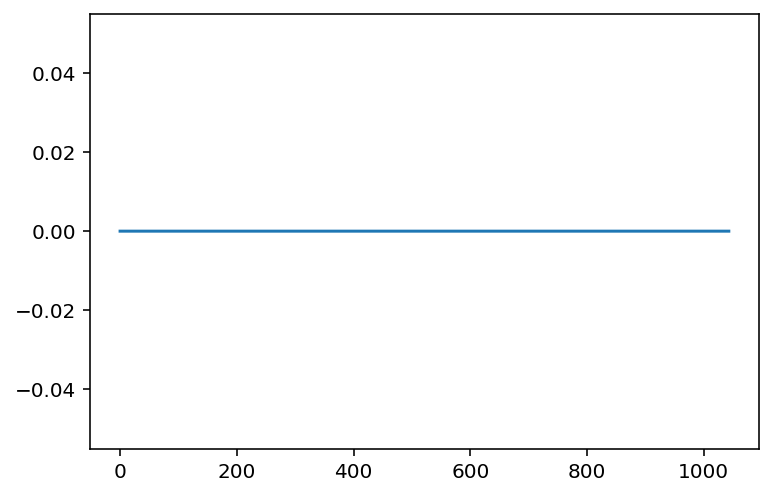

In [79]:
plt.plot(np.sum(m_wrong-m_tmp,axis=(1,2)))

In [195]:
expanded_shifts = cm.movie(origShifts.transpose((1,0,2))).resize(1,1,n_rebin)
# print (expanded_shifts.shape)
expanded_shifts = runningAverage(expanded_shifts,n_rebin*3)
expanded_shifts = expanded_shifts.transpose((1,0,2))
print (expanded_shifts.shape)

# %matplotlib inline

# plt.figure(figsize=(9,4))
# i,j = 0,0
# # plt.plot(np.linspace(0,1,len(m_rebinned)),origShifts[i,:,j],".-")
# plt.plot(rebin(time, n_rebin),.0+origShifts[i,:,j],".-",ms=3,lw=.7)
# plt.plot(time[:n_rebin*len(m_rebinned)],expanded_shifts[i,:,j],".",ms=3,lw=.7)
# plt.grid()

(2, 30276, 16)


In [196]:
rpad = orig_images.shape[0]-expanded_shifts.shape[1]
rpad = np.repeat(expanded_shifts[:,[-1]], rpad, axis=1)
expanded_shifts = np.concatenate([expanded_shifts,rpad],axis=1)

In [197]:
mc.x_shifts_els, mc.y_shifts_els = expanded_shifts

In [198]:
assert expanded_shifts.shape[1] == orig_images.shape[0]

In [202]:
fname_orig = cm.save_memmap([orig_images[:len(orig_images)//1]], base_name="orig", order='C', border_to_0=0, dview=dview)
mshifted = mc.apply_shifts_movie(fname_orig)

In [203]:
mshifted_rebinned = rebin(mshifted,n_rebin)

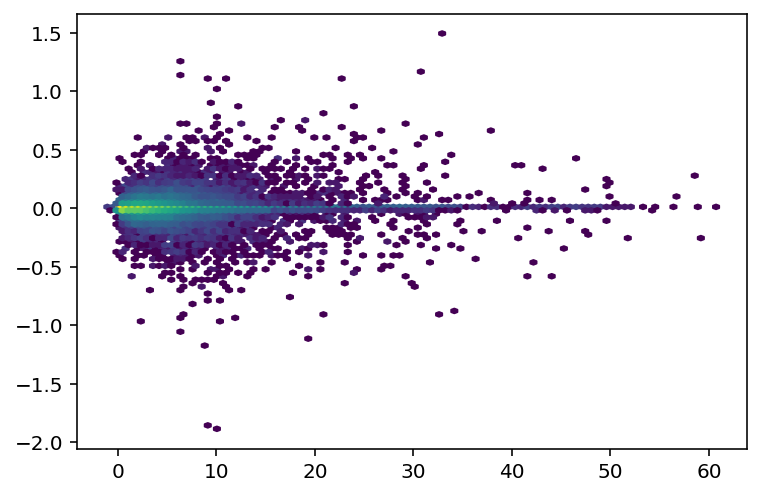

In [204]:
x,y = mshifted_rebinned,m_after_pwrigid[:len(mshifted_rebinned)]
x = x[::len(x)//40,::2,::2].flatten()
y = y[::len(y)//40,::2,::2].flatten()
plt.hexbin(x,x-y,mincnt=1,bins="log")

In [22]:
# th = m_rebinned.min()
# for m in ["m_rebinned","m_after_rigid","m_after_pwrigid","m_tmp"]:
#     try:
#         x = eval(m)
#         x = x[::len(x)//100,::3,::3].flatten()
#     except:
#         continue
#     c = plt.plot([])[0].get_color()
#     x.sort()
# #     for x,ls in zip([x,x[x>th]],["--","-"]):
#     for ls in["--","-"]:
#         if len(ls)==1:
#             x[x<th] = th

#         plt.plot(x,np.linspace(0,1,len(x)),lw=1,label=m,ls=ls,c=c)
# plt.xscale("symlog")
# plt.legend()

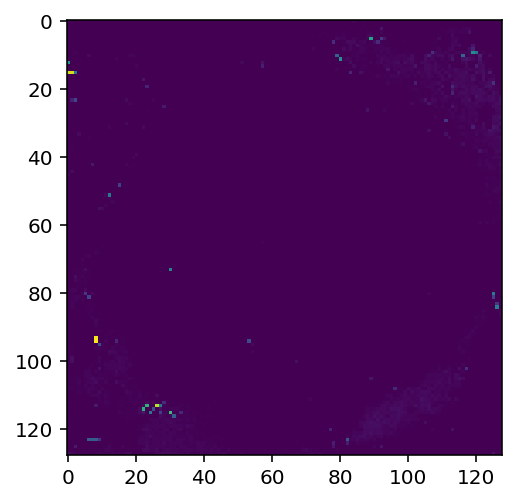

In [25]:
plt.imshow(np.mean(m_after_pwrigid<th,axis=0))

In [26]:
m_after_pwrigid[m_after_pwrigid<th] = th

In [27]:
from physio_def_1 import showMovie

In [28]:
nRebinShow = len(m_rebinned)//100

In [53]:
# border = rebin(np.ones_like(m_rebinned[:,:1])*m_rebinned.max(), nRebinShow)
# showMovie(np.log(cm.concatenate([
#     rebin(m_rebinned, nRebinShow),
#     border,
# #     rebin(m_after_rigid, nRebinShow),
# #     border,
#     rebin(m_after_pwrigid, nRebinShow),
# ],axis=1)),figsize=(13,6))

In [37]:
%%capture
from numeric import lowPass
wIron = 13
lowPass(mc.x_shifts_els[:,0],wIron,wIron,50.,2)

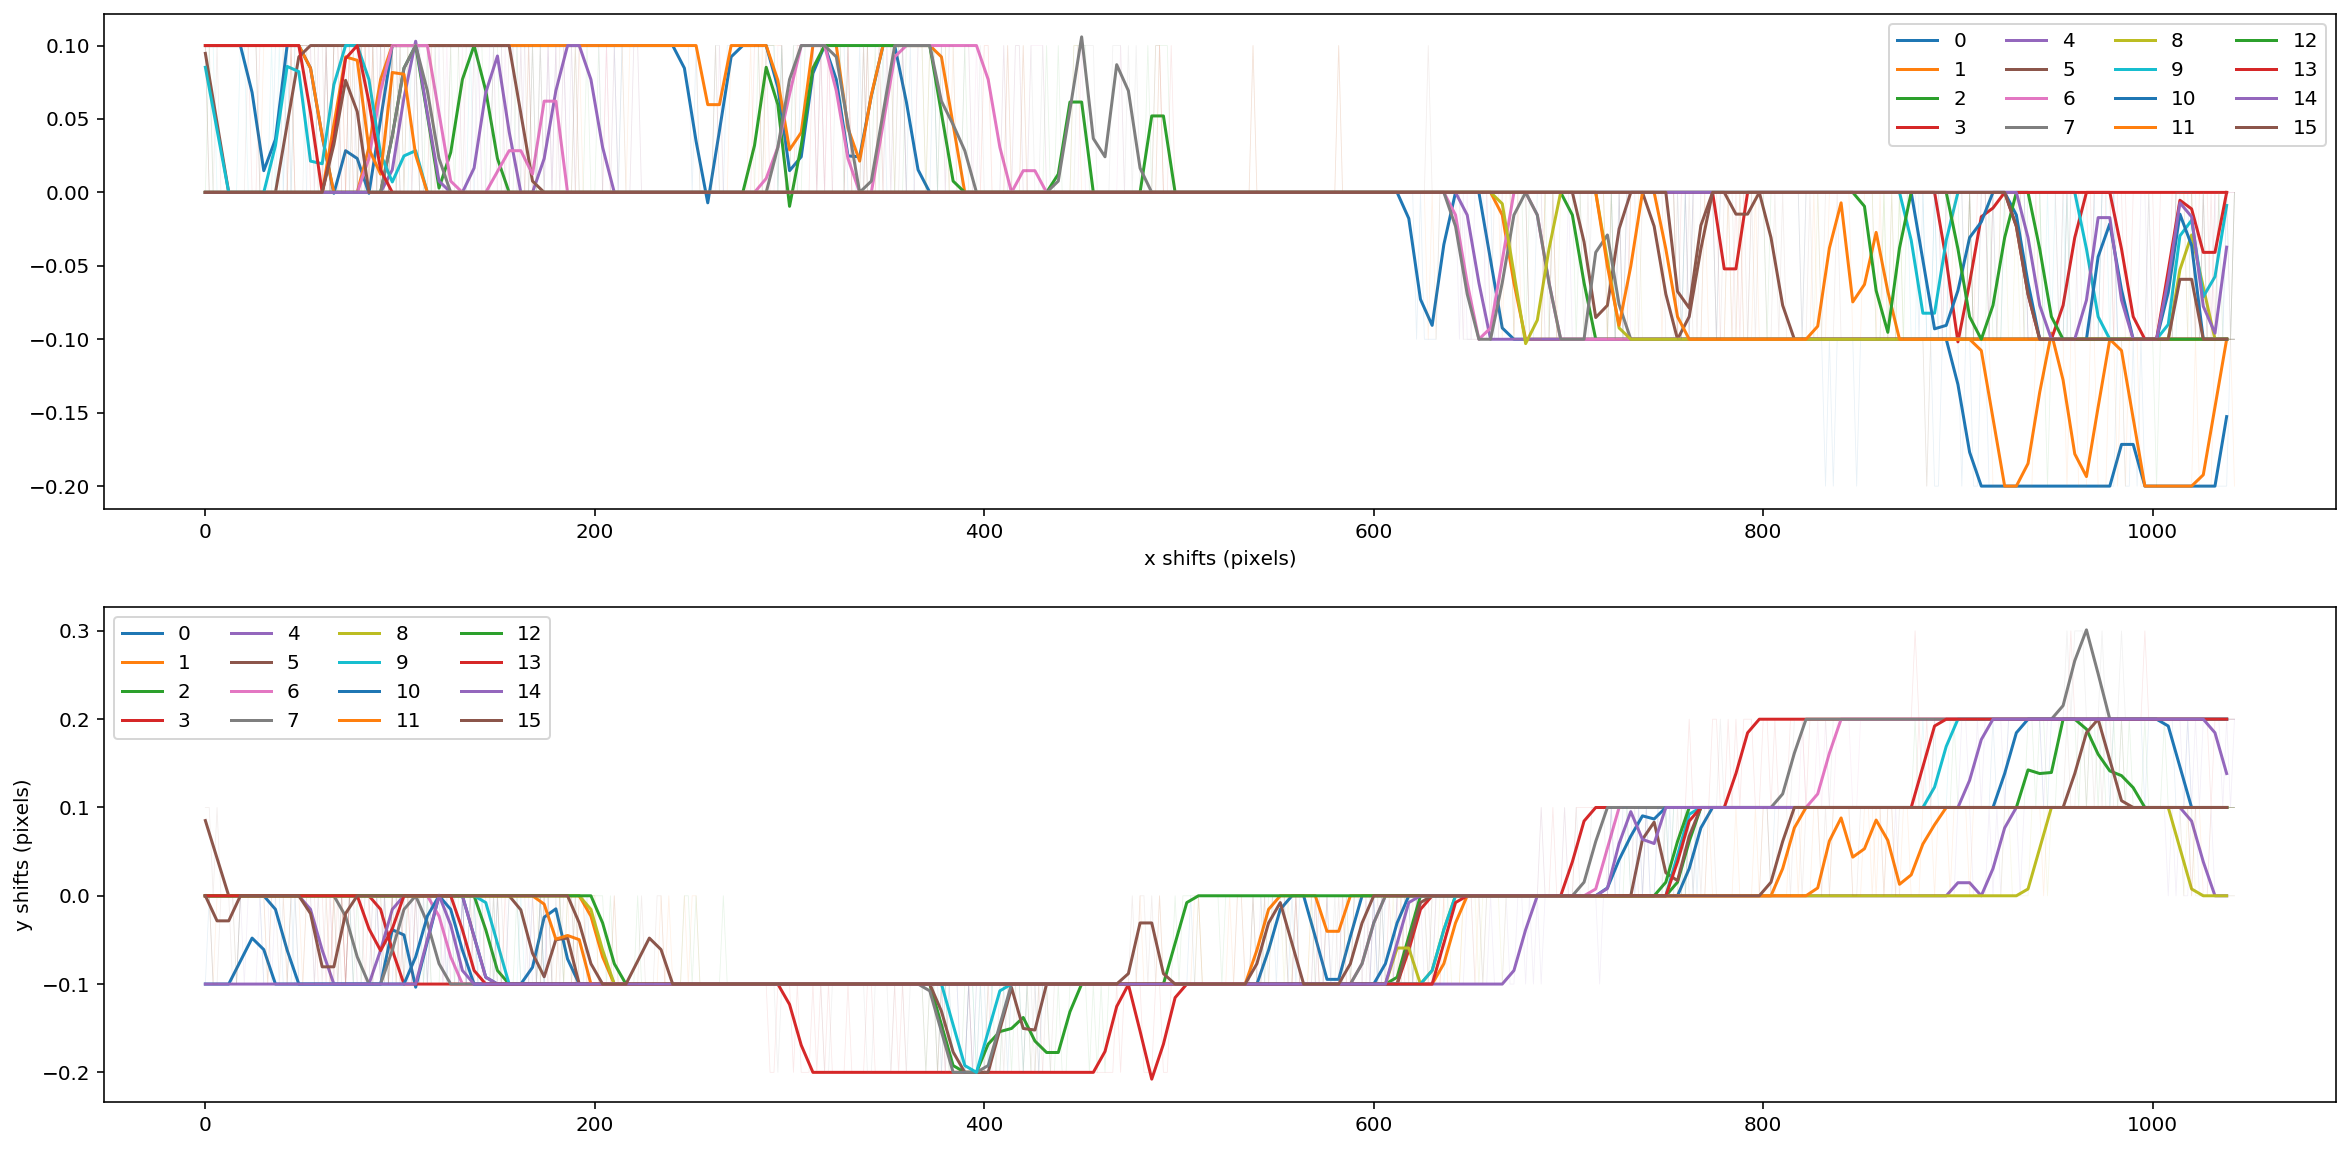

In [38]:
mc.x_shifts_els = np.array(mc.x_shifts_els)
mc.y_shifts_els = np.array(mc.y_shifts_els)

#%% visualize elastic shifts
plt.close()
fig, axs = plt.subplots(2,1,figsize = (20,10))

for i in range(mc.x_shifts_els.shape[1]):
# for i in range(1):
    c = plt.plot([])[0].get_color()
    for x,ax in zip([mc.x_shifts_els[:,i],mc.y_shifts_els[:,i]],axs):
        x = x
        ax.plot(np.arange(0,len(x),wIron//10+1),x[::wIron//10+1],c=c,
                lw=.4 if wIron>9 else .8,
                alpha = .1 if wIron>9 else 1
               )
        if wIron>9:
            ax.plot(np.arange(0,len(x),wIron//2),lowPass(x,wIron,wIron,50.,2)[::wIron//2], label=i,c=c)
if i<40:
    for ax in axs:
        ax.legend(ncol=4)
axs[0].set_xlabel('x shifts (pixels)')
axs[1].set_ylabel('y shifts (pixels)')

bord_px_els = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                 np.max(np.abs(mc.y_shifts_els)))).astype(np.int)

In [40]:
m_tmp = mc.apply_shifts_movie(mc.fname,
#                               rigid_shifts=False
                             )

100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


In [41]:
m_tmp-m_after_pwrigid

NameError: name 'm_after_pwrigid' is not defined

In [52]:
# m_tmp = mc.apply_shifts_movie(m_tmp, rigid_shifts=False)

In [62]:
m_tmp[m_tmp<th]=th

In [24]:
# border = rebin(np.ones_like(m_rebinned[:,:1])*m_rebinned.max(), nRebinShow)
# showMovie(np.log(cm.concatenate([
#     rebin(m_rebinned, nRebinShow),
# #     border,
# #     rebin(m_after_rigid, nRebinShow),
#     border,
#     rebin(m_after_pwrigid, nRebinShow),
#     border,
#     rebin(m_tmp, nRebinShow),
# ],axis=1)),figsize=(13,6))

In [101]:
m_tmp = m_rebinned.copy()
m_tmps = [m_tmp]
for i in range(4):
    tmpnames = cm.save_memmap([m_tmp], base_name="blabla", order='C', border_to_0=0, dview=dview)
#     m_tmp = cm.load_memmap(tmpnames)
#     m_tmp = m_tmp[0].reshape(m_tmp[1]+(m_tmp[0].shape[1],)).T
    m_tmp = mc.apply_shifts_movie(tmpnames, rigid_shifts=False)
    m_tmps += [m_tmp]

In [113]:
from copy import deepcopy

In [117]:
mc.x_shifts_els *= 10


In [119]:
m_tmp = mc.apply_shifts_movie(tmpnames, rigid_shifts=False)
m_tmps += [m_tmp]

In [25]:
# m_tmp = cm.concatenate(sum([[rebin(m,nRebinShow),border] for m in m_tmps[-2:]],[])[:-1], axis=1)
# m_tmp[m_tmp<th] = th
# showMovie(np.log(m_tmp), figsize=(13,5))

In [92]:
# showMovie(np.log(rebin(m_tmp2,nRebinShow)))

In [128]:
m_tmp = np.repeat(m_rebinned[:10],2,axis=0)

In [133]:
tmpnames = cm.save_memmap([m_tmp], base_name="blabla", order='C', border_to_0=0, dview=dview)

In [26]:
# mc.apply_shifts_movie(tmpnames, rigid_shifts=False)

In [36]:
# define new mc and apply shifts from here!!!!!

In [45]:
# motion correction parameters
opts = params.CNMFParams(params_dict={
#     'fnames'              : fnames,
#     "max_deviation_rigid" : 0,
    # 'max_shifts'        : (1, 1),  # maximum allowed rigid shift
    'border_nan'          : "copy",
#     'pw_rigid'            : pwRigid,
#     'gSig_filt'           : (3, 3),  # size of high pass spatial filtering, used in 1p data,
    'nonneg_movie'        : True
}) 

mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))

In [46]:
patchSizeAbs = 100 # in micrometers
patchSizePx = int(patchSizeAbs/metadata.pxSize)
if patchSizePx%2:
    patchSizePx -= 1

Lstride = int(patchSizePx*.7)
Loverlap = patchSizePx - Lstride
print (Lstride, Loverlap)

mc.strides  = (Lstride,)*2   # start a new patch for pw-rigid motion correction every x pixels,
mc.overlaps = (Loverlap,)*2  # between pathes (size of patch strides+overlaps),


32 14


In [47]:
mc.apply_shifts_movie?

In [ ]:
# mc.x_shifts_els.shape[1]

In [ ]:
from numeric import percFilter, lowPass

In [ ]:
%%capture
wIron = 11
lowPass(x[:100],wIron,wIron,50.)

In [ ]:
from numeric import runningAverage

In [ ]:
%%capture
runningAverage(x,11)

In [ ]:
wIron = 21
fig, axs = plt.subplots(2,1,figsize = (20,10))

# for i in range(mc.x_shifts_els.shape[1]):
for i in range(10):
    c = plt.plot([])[0].get_color()
    for x,ax in zip([mc.x_shifts_els[:,i],mc.y_shifts_els[:,i]],axs):
#         ax.plot(np.arange(0,len(x),wIron),runningAverage(x,wIron)[::wIron], c=c)
        ax.plot(runningAverage(x,wIron), c=c)
if i<40:
    for ax in axs:
        ax.legend(ncol=4)
axs[0].set_xlabel('x shifts (pixels)')
axs[1].set_ylabel('y shifts (pixels)')

bord_px_els = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                 np.max(np.abs(mc.y_shifts_els)))).astype(np.int)

In [78]:
Dmovie = np.diff(m_after_pwrigid)

In [79]:
Ss=Dmovie.std(axis=0)

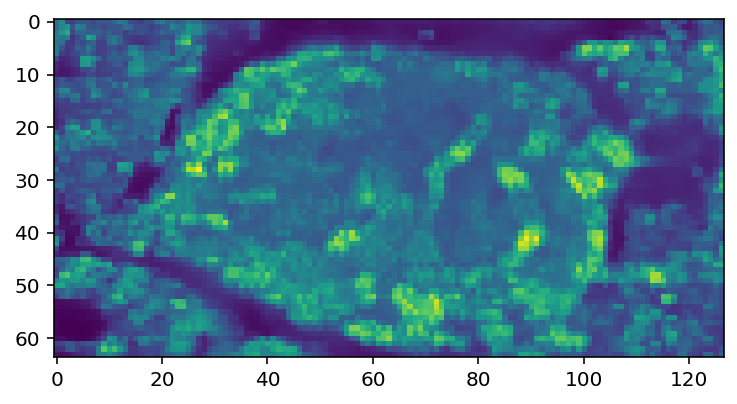

In [81]:
plt.imshow(np.log(Ss))

In [124]:
s = .6
blurredWeights = cv2.GaussianBlur(Ss,ksize=(5,5),sigmaX=s, sigmaY=s)

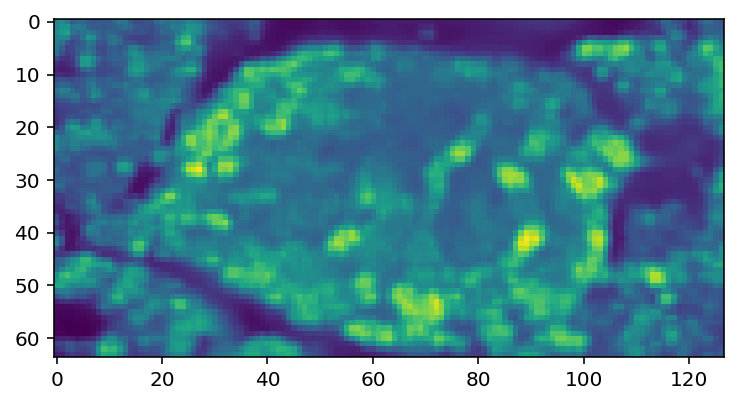

In [125]:
plt.imshow(np.log(blurredWeights))

In [126]:
# some definitions
def climb(x,blurredWeights,diag=True):
    dims = blurredWeights.shape
    # x = (60,60)
    x = x+(blurredWeights[x[0],x[1]],)
    xs = [x]
    # vs = pd.DataFrame(columns=["i","j","v"])
    for i in range(100):
        vs = []
        for di,dj in product([-1,0,1],[-1,0,1]):
            if not diag:
                if di*dj!=0: continue
            i,j = x[0]+di,x[1]+dj
            if i<0 or i>=dims[0] or j<0 or j>=dims[1]:
#                 print ("skipping")
                continue
        #     vs = vs.append({"i":i,"j":j,"v":blurredWeights[i,j]},ignore_index=True)
            vs += [(i,j,blurredWeights[i,j])]

        x1 = vs[np.argmax(vs,axis=0)[-1]]
        if x1[-1]<=x[-1]:
            break
        else:
            x = x1
            xs += [x]
    return x[:2]

def crawlDict(image, th=0, diag=False):
    A_ = [(i,j)+climb((i,j),image,diag=diag) for i,j in product(range(image.shape[0]),range(image.shape[1])) if image[i,j]>th]
    B_ = OrderedDict()
    for (i0,j0,i1,j1) in A_:
        if (i1,j1) not in B_:
            B_[(i1,j1)] = []
        B_[(i1,j1)] += [(i0,j0)]
    return B_

In [127]:
def edges2nodes(x,start=0,direction=1):
    if np.array(x[0]).shape != (2,2):
        x = [(el[:2],el[2:]) for el in x]
    nodes = list(x[start][::direction])

    for i in range(len(x)-1):
        nexts = [edge for edge in x if (edge[0]==nodes[-1] or edge[1]==nodes[-1])]
        for cand in np.unique(sum(nexts,()),axis=0):
            if tuple(cand) not in nodes:
                nodes += [tuple(cand)]
    return nodes

In [128]:
from itertools import product

In [129]:
from collections import OrderedDict

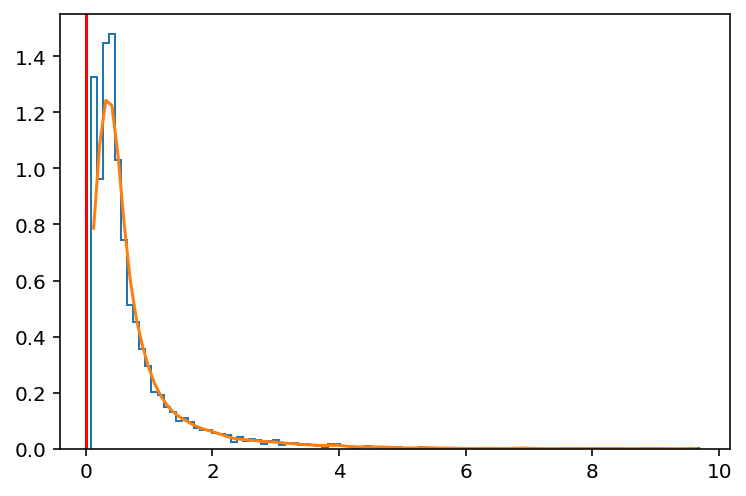

In [130]:
from scipy.stats import gaussian_kde
gkde = gaussian_kde(blurredWeights.flatten())
h,edges,_ = plt.hist(blurredWeights.flatten(),100,histtype="step",density=True);
bincenters = (edges[:-1]+edges[1:])/2
gkde_vals = gkde.evaluate(bincenters)
plt.plot(bincenters,gkde_vals)
th = bincenters[list(crawlDict(-gkde_vals.reshape(-1,1)+gkde_vals.max()+1,).keys())[1][0]-2]
if np.mean(blurredWeights>th)<.3:
    th = 0
# plt.hist(stdDimg.flatten(),50,histtype="step");
# th = 1.4#e[np.where(np.diff(np.diff(h)<0))[0][0]+1:][:2].mean()
plt.axvline(th,color="r")



In [131]:
testImage = blurredWeights[:,:]

In [132]:
B = crawlDict(testImage,th=th)

In [133]:
len(B)

368

In [134]:
dround = np.vstack([(-1,-1),(-1, 1),( 1, 1),( 1,-1),(-1,-1)])
# tmp = [(dx,dy) for dx,dy in dround]
# tmp += [tmp[0]]
dedges = []
for el in zip(dround[:-1],dround[1:]):
    el = np.array(el)+1
    el = np.vstack(sorted(el,key=np.linalg.norm))-1
#     dedges += [tuple(map(tuple,el*.5))]
    dedges += [el*.5]

dedges = np.stack(dedges)

In [135]:
toBreak = False
edgeID = OrderedDict()
for k in B:
    for x,y in B[k]:
        edges = dedges.copy()
        edges[...,0] += x
        edges[...,1] += y
        for edge in edges.reshape((-1,4)):
            edge = tuple(edge)
            if edge not in edgeID:
                edgeID[edge] = []
            edgeID[edge] += [k]
            if len(edgeID[edge])==2 and edgeID[edge][0]==edgeID[edge][1]:
                del edgeID[edge]


In [136]:
invEdgeID = OrderedDict()
for k in edgeID:
    for p in edgeID[k]:
        if p not in invEdgeID:
            invEdgeID[p] = []
        invEdgeID[p] += [k]

In [137]:
ks = list(B.keys())

In [138]:
neighborsMap = {k:[] for k in ks}
for edge in edgeID:
    if len(edgeID[edge])>1:
        for e1,e2 in product(edgeID[edge],edgeID[edge]):
            if e1==e2: continue
            if e2 not in neighborsMap[e1]:
                neighborsMap[e1] += [e2]

In [139]:
# remove rois smaller than Npx_min and without neighbors
Npx_min = 4
toRemove = []
for k in ks:
    n_pixels = len(B[k])
    n_neighbors = len(neighborsMap[k])
    if n_pixels<Npx_min and n_neighbors==0:
        toRemove += [k]
#         del B[k]
# del ks

In [140]:
len(B), len(toRemove)

(368, 0)

In [141]:
for k in toRemove:
    del B[k]

In [142]:
from collections import Counter

In [143]:
C = pd.DataFrame([],index=np.arange(len(B)))
C["peak"] = B.keys()
C["pixels"] = B.values()
C["center"] = [np.mean(C.loc[i,"pixels"], axis=0) for i in C.index]
C["size"] = list(map(len,C["pixels"]))
cnt = Counter(C['size'])
cnt = OrderedDict([(k,cnt[k]) for k in sorted(cnt.keys())])
len(C)

368

<ErrorbarContainer object of 3 artists>

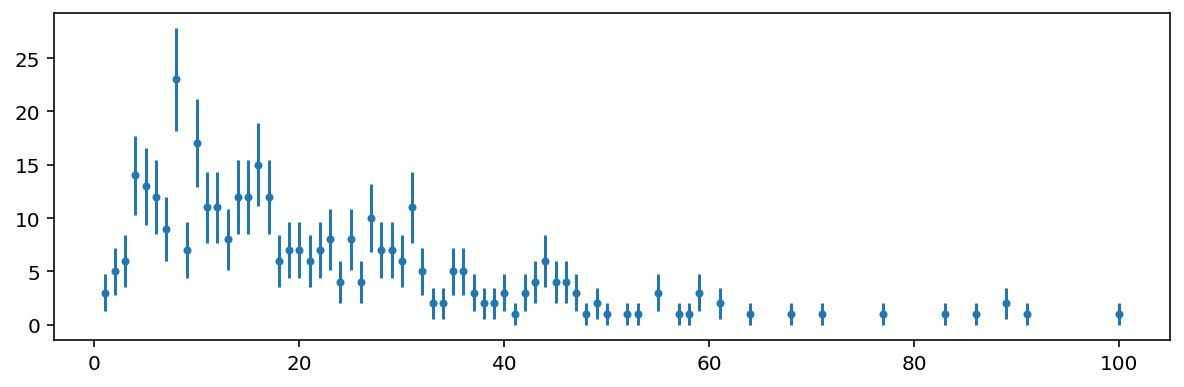

In [144]:
plt.figure(figsize=(10,3))
# plt.bar(cnt.keys(),cnt.values())
plt.errorbar(cnt.keys(),cnt.values(),np.array(list(cnt.values()))**.5,ls="none",marker=".")

In [145]:
from bidict import bidict
peak2idx = bidict([(peak,j) for j,peak in zip(C.index,C.peak)])
C["neighbors"] = [[peak2idx[p2] for p2 in neighborsMap[p1]] for p1 in C["peak"]]
C["Nneighbors"] = C["neighbors"].apply(len)
C["edges"] = [invEdgeID[p] for p in C.peak]

In [146]:
bd = []
for j in C.index:
    x = edges2nodes(C["edges"][j])
#     plt.plot(*np.array(x).T,marker=".")
    x = [x[i] for i in [0]+list(np.where(np.diff(np.diff(x,axis=0),axis=0).T[0]!=0)[0]+1)]
#     plt.plot(*np.array(x).T,marker="o", mfc="none")
    bd += [x]

C["boundary"] = list(bd)
del bd

In [226]:
C["peakValue"] = [testImage[p] for p in C.peak]

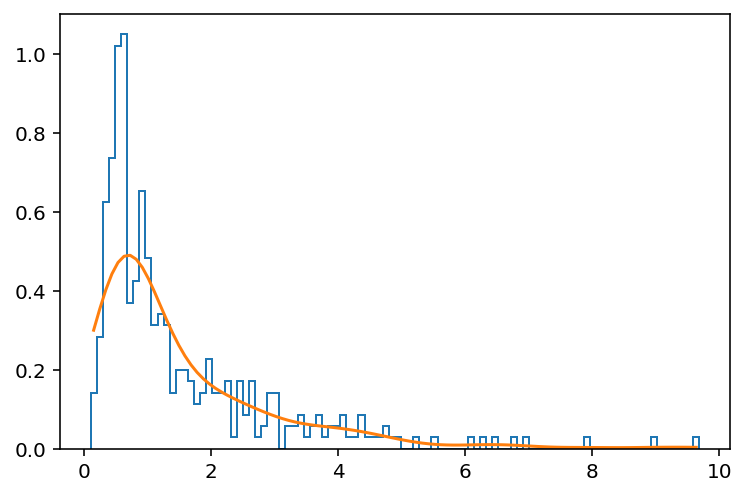

In [231]:
# plt.hist(,100);
x = C["peakValue"].values
gkde = gaussian_kde(x)
h,edges,_ = plt.hist(x,100,histtype="step",density=True);
bincenters = (edges[:-1]+edges[1:])/2
gkde_vals = gkde.evaluate(bincenters)
plt.plot(bincenters,gkde_vals)
# th = bincenters[list(crawlDict(-gkde_vals.reshape(-1,1)+gkde_vals.max()+1,).keys())[1][0]-2]
# if np.mean(blurredWeights>th)<.3:
#     th = 0
# plt.axvline(th,color="r")



In [147]:
from matplotlib.colors import LogNorm

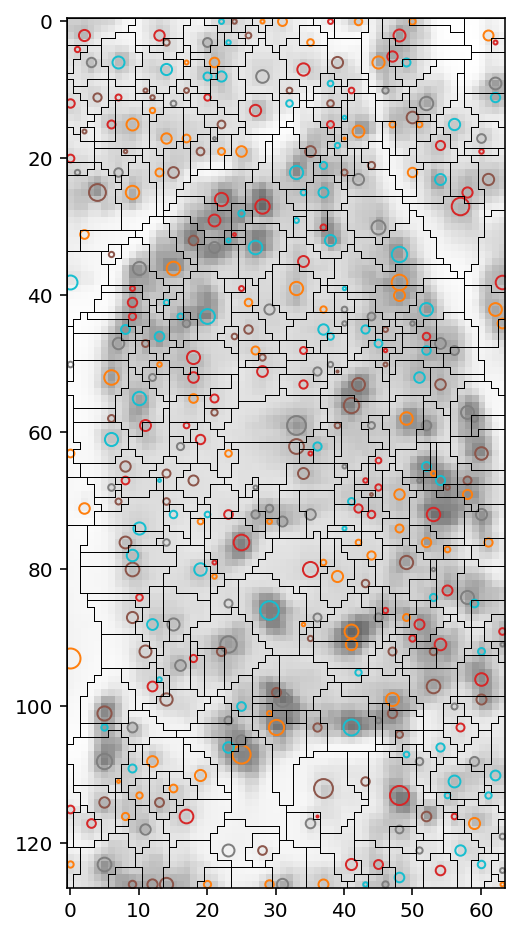

In [148]:
plt.figure(figsize=(7,8))
ax = plt.subplot(111)
ax.imshow(testImage.T,cmap="Greys",norm=LogNorm(),vmax=testImage.max()*10)

for i in C.sort_values("size",ascending=False).index[:]:
    c = plt.plot([])[0].get_color()
    x,y = C.loc[i,"peak"]#np.mean(C.loc[i,"pixels"],axis=0)
    plt.plot(x,y,"o",mfc="none",ms=C.loc[i,"size"]**.5)
#     plt.text(x,y,i)

for el in np.unique(sum(C["edges"],[]), axis=0):
    x,y = np.array(el).reshape((2,2)).T
    plt.plot(x,y,"k",lw=.5)
    

ax.set_aspect("equal")

In [152]:
i

236

In [151]:
C.loc[i,"neighbors"]

[219, 229]

In [169]:
distances = []
for i in C.index:
    for j in C.loc[i,"neighbors"]:
        if j<i: continue
        meanlocs = [np.mean(C.loc[i_,"pixels"],axis=0) for i_ in [i,j]]
        d_means = np.linalg.norm(np.diff(meanlocs,axis=0)[0])
        peaklocs = [C.loc[i_,"peak"] for i_ in [i,j]]
        d_peaks = np.linalg.norm(np.diff(peaklocs,axis=0)[0])
        distances += [OrderedDict([
            ("ids",(i,j)),
            ("means",d_means),
            ("peaks",d_peaks),
        ])]

In [170]:
distances = pd.DataFrame(distances)

In [171]:
import plotly_express as px

In [223]:
distances["candidates"] = distances.peaks<.5*distances.means
distances.loc[distances.peaks>4,"candidates"] = False
distances.loc[distances.peaks<2,"candidates"] = True

In [224]:
# px.scatter(distances.loc[::1],x="means", y="peaks",
# #            trendline="ols",
#            facet_col="candidates",
# #            color="candidates"
#           )

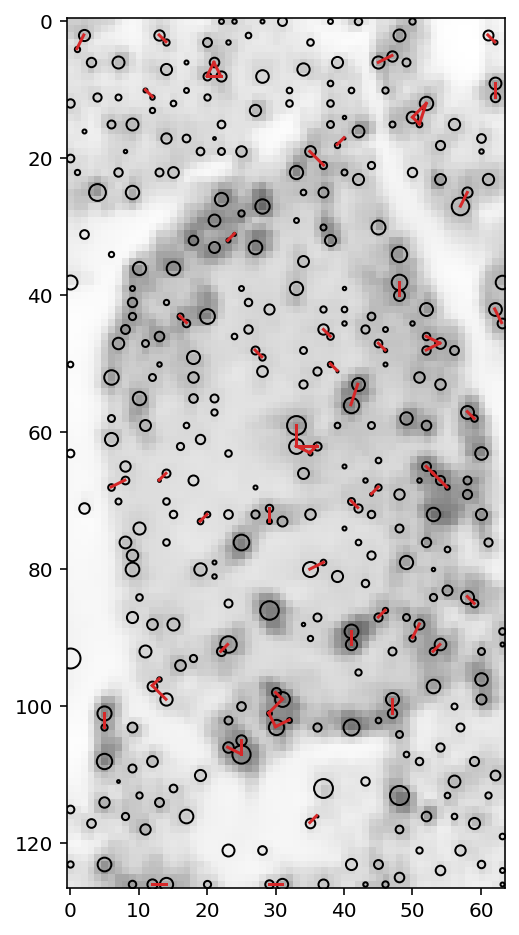

In [225]:
plt.figure(figsize=(7,8))
ax = plt.subplot(111)
ax.imshow(testImage.T,cmap="Greys",norm=LogNorm(),vmax=testImage.max()*10)

for i in C.sort_values("size",ascending=False).index[:]:
    c = "k"#plt.plot([])[0].get_color()
    x,y = C.loc[i,"peak"]#np.mean(C.loc[i,"pixels"],axis=0)
    plt.plot(x,y,"o",mfc="none",ms=C.loc[i,"size"]**.5,c=c)
#     plt.text(x,y,i)

# for el in np.unique(sum(C["edges"],[]), axis=0):
#     x,y = np.array(el).reshape((2,2)).T
#     plt.plot(x,y,"k",lw=.5)
for i,j in distances[distances.candidates].ids[:]:
    plt.plot(*np.vstack(C.loc[[i,j],"peak"].values).T,c="C3")
    

ax.set_aspect("equal")

In [167]:
d_peak, d_means

(5.0, 4.12521043234295)

4.12521043234295

In [149]:
def trace(pxs):
    return m_orig[(slice(None),)+tuple(np.array(pxs).T)].mean(axis=1)

In [233]:
traces = []
for i in C.index:
    traces += [trace(C.loc[i,"pixels"])]

In [234]:
traces[0].shape

(8533,)

In [161]:
mc = MotionCorrect(fname=mmapfile, dview=dview)

In [166]:
mc.strides  = ( LstrideX,  LstrideY)   # start a new patch for pw-rigid motion correction every x pixels,
mc.overlaps = (LoverlapX, LoverlapY)   # between pathes (size of patch strides+overlaps),
mc.max_deviation_rigid = 2             # maximum deviation allowed for patch with respect to rigid shifts

In [167]:
mc.pw_rigid = True

In [168]:
mc.motion_correct(save_movie=True)

ValueError: stat: embedded null character in path

In [130]:
pwshifts = m_orig_mmap.motion_correct(
    pw_rigid=True,
    
)

TypeError: motion_correct() got an unexpected keyword argument 'pw_rigid'

In [17]:
# create a motion correction object
mc = MotionCorrect(fnames,
                   dview=dview,
                   max_shifts=[3,3],
                   # strides=strides,
                   # overlaps=overlaps,
                   # max_deviation_rigid=3, 
                   # shifts_opencv=True,
                   # nonneg_movie=True,
                   # border_nan=True
                  )

In [24]:
mc.pw_rigid

False

In [19]:
# %%capture
# correct for rigid motion correction and save the file (in memory mapped form)
mc.motion_correct(save_movie=True)

ValueError: assignment destination is read-only

In [13]:
# m_orig = cm.movie(np.vstack(orig_images).astype("float32"))
# del orig_images

In [10]:
# fnames = 'Sue_2x_3000_40_-46.tif'
# fnames = [download_demo(fnames, save_folder="../../demo_data/")]     # the file will be downloaded if it doesn't already exist
# fnames = ["/Users/srdjan/Documents/Caiman_data/demo_data/Sue_2x_3000_40_-46.tif"]
# m_orig = cm.load_movie_chain(fnames)
# downsample_ratio = .2  # motion can be perceived better when downsampling in time
# m_orig[:100].resize(1, 1, downsample_ratio).play(q_max=99.5, fr=30, magnification=2)   # play movie (press q to exit)

Now set some parameters that are used for motion correction.

In [16]:
max_shifts = (6, 6)  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
strides =  (48, 48)  # create a new patch every x pixels for pw-rigid correction
overlaps = (24, 24)  # overlap between pathes (size of patch strides+overlaps)
num_frames_split = 100  # length in frames of each chunk of the movie (to be processed in parallel)
max_deviation_rigid = 3   # maximum deviation allowed for patch with respect to rigid shifts
pw_rigid = False  # flag for performing rigid or piecewise rigid motion correction
shifts_opencv = True  # flag for correcting motion using bicubic interpolation (otherwise FFT interpolation is used)
border_nan = 'copy'  # replicate values along the boundary (if True, fill in with NaN)

Note that here the data presented here has been downsampled in space by a factor of 2 to reduce the file size. As a result the spatial resolution is coarser here (around 2 microns per pixel). If we were operating at the original resolution, several of the parameters above, e.g., ```max_shifts, strides, overlaps, max_deviation_rigid```, could have been larger by a factor of 2.

In [17]:
import os
print (os.environ["MKL_NUM_THREADS"])
print (os.environ["OPENBLAS_NUM_THREADS"])

1
1


###### Motion correction is performed in parallel on chunks taken across times.

We first a cluster. The default backend mode for parallel processing is through the multiprocessing package. To make sure that this package is viewable from everywhere before starting the notebook these commands need to be executed from the terminal (in Linux and Windows):
```bash
   export MKL_NUM_THREADS=1
   export OPENBLAS_NUM_THREADS=1 
   ```

In [18]:
#%% start the cluster (if a cluster already exists terminate it)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

We first need to create a motion correction object with the parameters specified above. We pass directly its input arguments in the constructor below. Alternatively, we can use the `params` object and construct it by passing the arguments of `params.motion`. See the notebook `demo_pipeline.ipynb` for an example of this usage.

In [21]:
# create a motion correction object
mc = MotionCorrect(fnames, dview=dview, max_shifts=max_shifts,
                  strides=strides, overlaps=overlaps,
                  max_deviation_rigid=max_deviation_rigid, 
                  shifts_opencv=shifts_opencv, nonneg_movie=True,
                  border_nan=border_nan)

<h1> Rigid motion correction</h1>
<p> The original file exhibits a lot of motion. In order to correct for it we are first trying a simple rigid motion correction algorithm. This has already been selected by setting the parameter `pw_rigid=False` during the construction of the `MotionCorrect` object. The algorithm first creates a template by averaging frames from the video. It then tries to match each frame to this template. In addition the template will get updated during the matching process, resulting in a single precise template that is used for subpixel registration.  </p>
<img src="../../docs/img/rigidcorrection.png" />

In [22]:
%%capture
# correct for rigid motion correction and save the file (in memory mapped form)
mc.motion_correct(save_movie=True)

ValueError: assignment destination is read-only

The motion corrected file is automatically save as memory mapped file in the location given by `mc.mmap_file`. The rigid shifts are also save in `mc.shifts_rig`. 

In [23]:
dir(mc)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'apply_shifts_movie',
 'border_nan',
 'dview',
 'fname',
 'fname_tot_rig',
 'gSig_filt',
 'indices',
 'is3D',
 'max_deviation_rigid',
 'max_shifts',
 'min_mov',
 'motion_correct',
 'motion_correct_pwrigid',
 'motion_correct_rigid',
 'niter_rig',
 'nonneg_movie',
 'num_splits_to_process_els',
 'num_splits_to_process_rig',
 'overlaps',
 'pw_rigid',
 'shifts_opencv',
 'shifts_rig',
 'splits_els',
 'splits_rig',
 'strides',
 'templates_rig',
 'total_template_rig',
 'upsample_factor_grid',
 'use_cuda',
 'var_name_hdf5']

In [33]:
# # load motion corrected movie
# m_rig = cm.load(mc.mmap_file)
# bord_px_rig = np.ceil(np.max(mc.shifts_rig)).astype(np.int)
# #%% visualize templates
# plt.figure(figsize = (20,10))
# plt.imshow(mc.total_template_rig, cmap = 'gray')

In [12]:
#%% inspect movie
m_rig.resize(1, 1, downsample_ratio).play(
    q_max=99.5, fr=30, magnification=2, bord_px = 0*bord_px_rig) # press q to exit

plot the shifts computed by rigid registration

In [32]:
# #%% plot rigid shifts
# plt.close()
# plt.figure(figsize = (20,10))
# plt.plot(mc.shifts_rig)
# plt.legend(['x shifts','y shifts'])
# plt.xlabel('frames')
# plt.ylabel('pixels')

## Piecewise rigid registration
While rigid registration corrected for a lot of the movement, there is still non-uniform motion present in the registered file. To correct for that we can use piece-wise rigid registration **directly in the original file** by setting `mc.pw_rigid=True`. As before the registered file is saved in a memory mapped format in the location given by `mc.mmap_file`.

In [14]:
%%capture
#%% motion correct piecewise rigid
mc.pw_rigid = True  # turn the flag to True for pw-rigid motion correction
mc.template = mc.mmap_file  # use the template obtained before to save in computation (optional)

mc.motion_correct(save_movie=True, template=mc.total_template_rig)
m_els = cm.load(mc.fname_tot_els)
m_els.resize(1, 1, downsample_ratio).play(
    q_max=99.5, fr=30, magnification=2,bord_px = bord_px_rig)

Now concatenate all the movies (raw, rigid, and pw-rigid) for inspection

In [ ]:
cm.concatenate([m_orig.resize(1, 1, downsample_ratio) - mc.min_mov*mc.nonneg_movie,
                m_rig.resize(1, 1, downsample_ratio), m_els.resize(
            1, 1, downsample_ratio)], axis=2).play(fr=60, q_max=99.5, magnification=2, bord_px=bord_px_rig,do_loop=True)

From the movie we can see that pw-rigid registration corrected for the non uniform motion of the data. This was done by estimating different displacement vectors for the different patches in the FOV. This can be visualized by plotting all the computed shifts were a dispersion in the shifts in the y direction is apparent. In this case, the shifts along the two axes are stored in `mc.x_shifts_els` and `mc.y_shifts_els`, respectively.

In [31]:
# #%% visualize elastic shifts
# plt.close()
# plt.figure(figsize = (20,10))
# plt.subplot(2, 1, 1)
# plt.plot(mc.x_shifts_els)
# plt.ylabel('x shifts (pixels)')
# plt.subplot(2, 1, 2)
# plt.plot(mc.y_shifts_els)
# plt.ylabel('y_shifts (pixels)')
# plt.xlabel('frames')
# #%% compute borders to exclude
# bord_px_els = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
#                                  np.max(np.abs(mc.y_shifts_els)))).astype(np.int)

The improvement in performance can also be seen by a more crisp summary statistic image. Below we plot the correlation images for the three datasets.

In [31]:
m_orig.local_correlations?

In [30]:
# plt.figure(figsize = (20,10))
# plt.subplot(1,3,1); plt.imshow(m_orig.local_correlations(eight_neighbours=True, swap_dim=False))
# plt.subplot(1,3,2); plt.imshow(m_rig.local_correlations(eight_neighbours=True, swap_dim=False))
# plt.subplot(1,3,3); plt.imshow(m_els.local_correlations(eight_neighbours=True, swap_dim=False))

In [32]:
cm.stop_server(dview=dview) # stop the server

## Quality assessment 

Apart from inspection, the performance of the registration methods can be quantified using several measures. Below we compute measures such as correlation of each frame with mean, crispness of summary image, and residual optical flow for all three cases. For more info see [[1]](#normcorre). Note that computation of the residual optical flow can be computationally intensive.

In [33]:
%%time 
%%capture
#% compute metrics for the results (TAKES TIME!!)
final_size = np.subtract(mc.total_template_els.shape, 2 * bord_px_els) # remove pixels in the boundaries
winsize = 100
swap_dim = False
resize_fact_flow = .2    # downsample for computing ROF

tmpl_rig, correlations_orig, flows_orig, norms_orig, crispness_orig = cm.motion_correction.compute_metrics_motion_correction(
    fnames[0], final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_rig, correlations_rig, flows_rig, norms_rig, crispness_rig = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_rig[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_els, correlations_els, flows_els, norms_els, crispness_els = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_els[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

CPU times: user 56.1 s, sys: 5.1 s, total: 1min 1s
Wall time: 1min 3s


In [39]:
from matplotlib.colors import LogNorm

In [29]:
# m = m_orig[:100].mean(0)
# # plt.imshow(m-m.min()+1,norm=LogNorm())
# plt.imshow(m.max()-m-1,)

In [36]:
m_orig[:10].sum(axis=0)

movie([[-2557., -2673., -2681., ..., -2625., -2679., -2642.],
       [-2272., -2526., -2374., ..., -2638., -2473., -2579.],
       [-2595., -2705., -2646., ..., -2574., -2583., -2595.],
       ...,
       [-2695., -2726., -2668., ..., -2385., -2384., -2750.],
       [-2678., -2731., -2768., ..., -2640., -2693., -2676.],
       [-2696., -2705., -2772., ..., -2377., -2513., -2573.]],
      dtype=float32)

In [35]:
m_rig.dtype

dtype('float32')

Plot correlation with mean frame for each dataset

In [28]:
# plt.figure(figsize = (20,10))
# plt.subplot(211); plt.plot(correlations_orig); plt.plot(correlations_rig); plt.plot(correlations_els)
# plt.legend(['Original','Rigid','PW-Rigid'])
# plt.subplot(223); plt.scatter(correlations_orig, correlations_rig); plt.xlabel('Original'); 
# plt.ylabel('Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
# axes = plt.gca(); axes.set_xlim([0.3,0.7]); axes.set_ylim([0.3,0.7]); plt.axis('square');
# plt.subplot(224); plt.scatter(correlations_rig, correlations_els); plt.xlabel('Rigid'); 
# plt.ylabel('PW-Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
# axes = plt.gca(); axes.set_xlim([0.3,0.7]); axes.set_ylim([0.3,0.7]); plt.axis('square');


In [48]:
# print crispness values
print('Crispness original: '+ str(int(crispness_orig)))
print('Crispness rigid: '+ str(int(crispness_rig)))
print('Crispness elastic: '+ str(int(crispness_els)))

Crispness original: 1937
Crispness rigid: 2759
Crispness elastic: 2847


In [27]:
# #%% plot the results of Residual Optical Flow
# fls = [mc.fname_tot_els[0][:-4] + '_metrics.npz', mc.fname_tot_rig[0][:-4] +
#        '_metrics.npz', mc.fname[0][:-4] + '_metrics.npz']

# plt.figure(figsize = (20,10))
# for cnt, fl, metr in zip(range(len(fls)),fls,['pw_rigid','rigid','raw']):
#     with np.load(fl) as ld:
#         print(ld.keys())
#         print(fl)
#         print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
#               ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))
        
#         plt.subplot(len(fls), 3, 1 + 3 * cnt)
#         plt.ylabel(metr)
#         try:
#             mean_img = np.mean(
#             cm.load(fl[:-12] + 'mmap'), 0)[12:-12, 12:-12]
#         except:
#             try:
#                 mean_img = np.mean(
#                     cm.load(fl[:-12] + '.tif'), 0)[12:-12, 12:-12]
#             except:
#                 mean_img = np.mean(
#                     cm.load(fl[:-12] + 'hdf5'), 0)[12:-12, 12:-12]
                    
#         lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
#         plt.imshow(mean_img, vmin=lq, vmax=hq)
#         plt.title('Mean')
#         plt.subplot(len(fls), 3, 3 * cnt + 2)
#         plt.imshow(ld['img_corr'], vmin=0, vmax=.35)
#         plt.title('Corr image')
#         plt.subplot(len(fls), 3, 3 * cnt + 3)
#         #plt.plot(ld['norms'])
#         #plt.xlabel('frame')
#         #plt.ylabel('norm opt flow')
#         #plt.subplot(len(fls), 3, 3 * cnt + 3)
#         flows = ld['flows']
#         plt.imshow(np.mean(
#         np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.3)
#         plt.colorbar()
#         plt.title('Mean optical flow')      